# Question Answering with Memory

This model shows a form of question answering with memory. You will bind two features
(color and shape) by circular convolution and store them in a memory population. Then
you will provide a cue to the model at a later time to determine either one of the
features by deconvolution. This model exhibits better cognitive ability since the
answers to the questions are provided at a later time and not at the same time as the
questions themselves.

**Note**: Simplified method of building the model using the SPA (semantic pointer
architecture) package in Nengo 2.0 is shown in the last few sections of this notebook.

In [1]:
# Setup the environment
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

import nengo
from nengo.spa import Vocabulary

## Create the model
This model has parameters as described in the book, with `memory` population having 1000
neurons over 20 dimensions. The `memory` population is capable of storing a vector over
time and it uses an integrator network to do so as discussed in the book.

The color input presented to the model is **RED** and then **BLUE** for 0.25 seconds
each
before being turned off. In the same way the shape input is **CIRCLE** and then
**SQUARE**
for 0.25 seconds each. Thus, when you run the model, it will start by binding **RED**
and
**CIRCLE** for 0.25 seconds and then binding **BLUE** and **SQUARE** for 0.25 seconds.
The cue
for deconvolving bound semantic pointers will be turned off for 0.5 seconds and then
starts cycling through **CIRCLE**, **RED**, **SQUARE**, and **BLUE** within each second.
The
model will be able to determine the correct answer using the cue, even when the color
and shape inputs have been turned off.

In [2]:
dim = 32  # Number of dimensions
n_neurons = 300  # Number of neurons in population
n_conv = 70  # Number of neurons per dimension in bind/unbind populations
n_mem = 50  # Number of neurons per dimension in memory population

# Creating the vocabulary
rng = np.random.RandomState(0)
vocab = Vocabulary(dimensions=dim, rng=rng, max_similarity=0.1)

model = nengo.Network(label="Question Answering with Memory", seed=12)
with model:
    # Ensembles
    ens_A = nengo.Ensemble(n_neurons=n_neurons, dimensions=dim, label="A")
    ens_B = nengo.Ensemble(n_neurons=n_neurons, dimensions=dim, label="B")
    ens_C = nengo.Ensemble(n_neurons=n_neurons, dimensions=dim, label="C")
    ens_D = nengo.Ensemble(n_neurons=n_neurons, dimensions=dim, label="D")
    ens_E = nengo.Ensemble(n_neurons=n_neurons, dimensions=dim, label="E")

    # Creating memory population and connecting ensemble D to it
    tau = 0.4
    memory = nengo.networks.EnsembleArray(
        n_neurons=n_mem,
        n_ensembles=dim,
        label="Memory",
    )
    nengo.Connection(memory.output, memory.input, synapse=tau)
    nengo.Connection(ens_D, memory.input)

    # Creating the Bind network
    net_bind = nengo.networks.CircularConvolution(n_neurons=n_conv, dimensions=dim)
    nengo.Connection(ens_A, net_bind.A)
    nengo.Connection(ens_B, net_bind.B)
    nengo.Connection(net_bind.output, ens_D)

    # Creating the Unbind network
    net_unbind = nengo.networks.CircularConvolution(
        n_neurons=n_conv, dimensions=dim, invert_a=True
    )
    nengo.Connection(ens_C, net_unbind.A)
    nengo.Connection(memory.output, net_unbind.B)
    nengo.Connection(net_unbind.output, ens_E)

    # Getting semantic pointer values
    CIRCLE = vocab.parse("CIRCLE").v
    BLUE = vocab.parse("BLUE").v
    RED = vocab.parse("RED").v
    SQUARE = vocab.parse("SQUARE").v
    ZERO = [0] * dim

    # Function for providing color input
    def color_input(t):
        if t < 0.25:
            return RED
        elif t < 0.5:
            return BLUE
        return ZERO

    # Function for providing shape input
    def shape_input(t):
        if t < 0.25:
            return CIRCLE
        elif t < 0.5:
            return SQUARE
        return ZERO

    # Function for providing the cue
    def cue_input(t):
        if t < 0.5:
            return ZERO
        sequence = [ZERO, CIRCLE, RED, ZERO, SQUARE, BLUE]
        idx = int(((t - 0.5) // (1.0 / len(sequence))) % len(sequence))
        return sequence[idx]

    # Defining inputs
    input_A = nengo.Node(output=color_input, size_out=dim, label="Input A")
    input_B = nengo.Node(output=shape_input, size_out=dim, label="Input B")
    input_C = nengo.Node(output=cue_input, size_out=dim, label="Input C")

    # Connecting input to ensembles
    nengo.Connection(input_A, ens_A)
    nengo.Connection(input_B, ens_B)
    nengo.Connection(input_C, ens_C)

## Add Probes to Collect Data

In [3]:
with model:
    A_probe = nengo.Probe(ens_A, synapse=0.03)
    B_probe = nengo.Probe(ens_B, synapse=0.03)
    C_probe = nengo.Probe(ens_C, synapse=0.03)
    D_probe = nengo.Probe(ens_D, synapse=0.03)
    E_probe = nengo.Probe(ens_E, synapse=0.03)
    memory_probe = nengo.Probe(memory.output, synapse=0.03)

## Run the model

In [4]:
with nengo.Simulator(model) as sim:  # Create the simulator
    sim.run(3.0)  # Run it for 3 seconds

## Plot the results

Text(0.5, 0, 'time [s]')

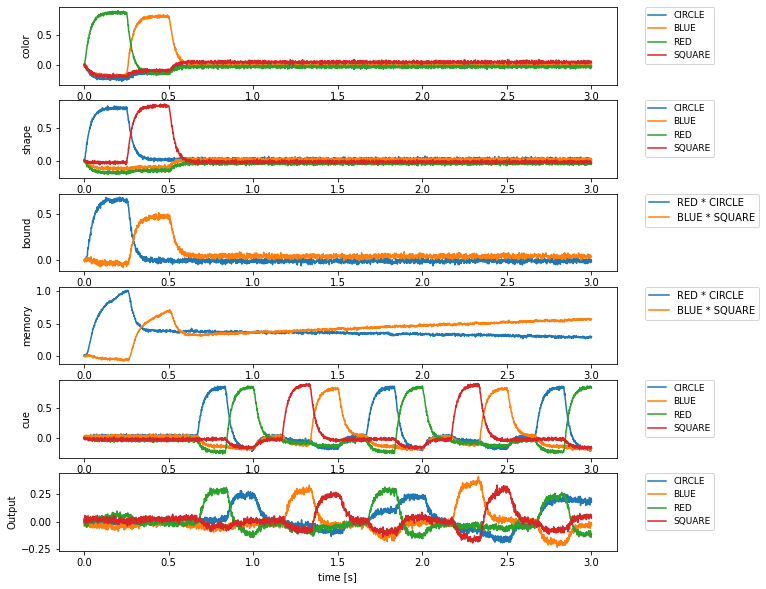

In [5]:
plt.figure(figsize=(10, 10))

plt.subplot(6, 1, 1)
plt.plot(sim.trange(), nengo.spa.similarity(sim.data[A_probe], vocab))
plt.legend(vocab.keys, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0, fontsize=9)
plt.ylabel("color")

plt.subplot(6, 1, 2)
plt.plot(sim.trange(), nengo.spa.similarity(sim.data[B_probe], vocab))
plt.legend(vocab.keys, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0, fontsize=9)
plt.ylabel("shape")

plt.subplot(6, 1, 3)
for pointer in ["RED * CIRCLE", "BLUE * SQUARE"]:
    plt.plot(sim.trange(), vocab.parse(pointer).dot(sim.data[D_probe].T), label=pointer)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0, fontsize=10)
plt.ylabel("bound")

plt.subplot(6, 1, 4)
for pointer in ["RED * CIRCLE", "BLUE * SQUARE"]:
    plt.plot(
        sim.trange(), vocab.parse(pointer).dot(sim.data[memory_probe].T), label=pointer
    )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0, fontsize=10)
plt.ylabel("memory")

plt.subplot(6, 1, 5)
plt.plot(sim.trange(), nengo.spa.similarity(sim.data[C_probe], vocab))
plt.legend(vocab.keys, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0, fontsize=9)
plt.ylabel("cue")

plt.subplot(6, 1, 6)
plt.plot(sim.trange(), nengo.spa.similarity(sim.data[E_probe], vocab))
plt.legend(vocab.keys, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0, fontsize=9)
plt.ylabel("Output")
plt.xlabel("time [s]")

The graphs of `shape`, `color`, `bound` and `memory` show that first **RED * CIRCLE**
and
then **BLUE * SQUARE** are convolved (bound) and loaded into the `memory` population, so
after 0.5 seconds the `memory` represents the superposition **RED * CIRCLE + BLUE *
SQUARE**.

The last plot shows that the output is most similar to the semantic pointer bound to the
current cue. For example, when the cue is **CIRCLE**, the output is most similar to
**RED**.

## Create the model using the `nengo.spa` package

In [6]:
from nengo import spa

dim = 32  # The dimensionality of the vectors
rng = np.random.RandomState(4)
vocab = Vocabulary(dimensions=dim, rng=rng, max_similarity=0.1)

# Adding semantic pointers to the vocabulary
CIRCLE = vocab.parse("CIRCLE")
BLUE = vocab.parse("BLUE")
RED = vocab.parse("RED")
SQUARE = vocab.parse("SQUARE")
ZERO = vocab.add("ZERO", [0] * dim)

# Create the spa.SPA network to which we can add SPA objects
model = spa.SPA(label="Question Answering with Memory", vocabs=[vocab])
with model:
    model.A = spa.State(dim)
    model.B = spa.State(dim)
    model.C = spa.State(dim)
    model.D = spa.State(dim)
    model.E = spa.State(dim)
    model.memory = spa.State(dim, feedback=1)

    actions = spa.Actions("D = A * B", "memory = D", "E = memory * ~C")

    model.cortical = spa.Cortical(actions)

    # Function for providing color input
    def color_input(t):
        if t < 0.25:
            return "RED"
        elif t < 0.5:
            return "BLUE"
        return "ZERO"

    # Function for providing shape input
    def shape_input(t):
        if t < 0.25:
            return "CIRCLE"
        elif t < 0.5:
            return "SQUARE"
        return "ZERO"

    # Function for providing the cue
    def cue_input(t):
        if t < 0.5:
            return "ZERO"
        sequence = ["ZERO", "CIRCLE", "RED", "ZERO", "SQUARE", "BLUE"]
        idx = int(((t - 0.5) // (1.0 / len(sequence))) % len(sequence))
        return sequence[idx]

    # Inputs
    model.input = spa.Input(A=color_input, B=shape_input, C=cue_input)

## Run the model in `nengo_gui`

In [ ]:
from nengo_gui.ipython import IPythonViz

IPythonViz(model, "ch5-question-memory.py.cfg")

Press the play button in the visualizer to run the simulation. You should see the
"semantic pointer cloud" graphs as shown in the figure below.

Graphs `A`, `B`, `C` show the colour, shape and cue inputs respectively. Graph `E` shows
that
the output is most similar to the semantic pointer which was initially bound to the
given cue (showin in `C`). For example, when **SQUARE** is provided as a cue, the output
is
most similar to **BLUE**.

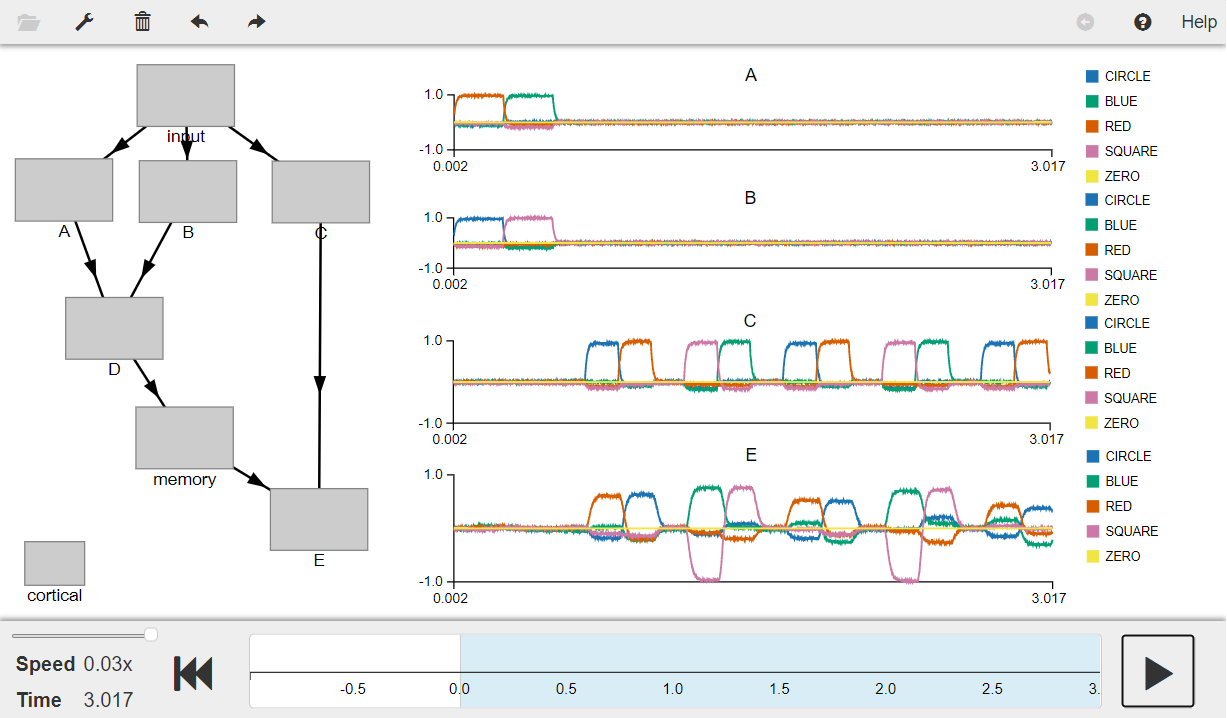

In [7]:
from IPython.display import Image

Image(filename="ch5-question-memory.png")